STEP 1: DATASET LOADING AND DATA AUGMENTATION

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define dataset paths
train_dir = 'dataset/Lung_Cancer_Dataset/train'
test_dir = 'dataset/Lung_Cancer_Dataset/test'

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Load and augment the dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 364 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


STEP 2: BUILD AND TRAIN DENSE NET MODEL

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

# Build DenseNet model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model_densenet = models.Sequential()
model_densenet.add(base_model_densenet)
model_densenet.add(layers.GlobalAveragePooling2D())
model_densenet.add(layers.Dense(1, activation='sigmoid'))

# Freeze the pre-trained layers
for layer in base_model_densenet.layers:
    layer.trainable = False

# Compile the model
model_densenet.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32)


29084464/29084464 [==============================] - 6s 0us/step


Epoch 1/10
11/11 [==============================] - 25s 2s/step - loss: 0.6787 - accuracy: 0.6446 - val_loss: 0.5507 - val_accuracy: 0.7312
Epoch 2/10
11/11 [==============================] - 16s 2s/step - loss: 0.3744 - accuracy: 0.8825 - val_loss: 0.3942 - val_accuracy: 0.8500
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 0.2749 - accuracy: 0.9066 - val_loss: 0.2561 - val_accuracy: 0.9187
Epoch 4/10
11/11 [==============================] - 17s 2s/step - loss: 0.2155 - accuracy: 0.9458 - val_loss: 0.1782 - val_accuracy: 0.9688
Epoch 5/10
11/11 [==============================] - 17s 2s/step - loss: 0.1771 - accuracy: 0.9699 - val_loss: 0.1316 - val_accuracy: 0.9937
Epoch 6/10
11/11 [==============================] - 17s 2s/step - loss: 0.1324 - accuracy: 0.9759 - val_loss: 0.1469 - val_accuracy: 0.9438
Epoch 7/10
11/11 [==============================] - 17s 2s/step - loss: 0.1220 - accuracy: 0.9699 - val_loss: 0.1029 - val_accuracy: 0.9937
Epoch 8/10
11/11 [==

In [4]:
history_densenet.save("densenet_model.h5")


NameError: name 'history_densenet' is not defined

STEP 3: BUILD AND TRAIN ALEXNET MODEL

In [10]:
from tensorflow.keras import layers, models

def AlexNet(input_shape):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.BatchNormalization())

    # Second convolutional layer
    model.add(layers.Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.BatchNormalization())

    # Third convolutional layer
    model.add(layers.Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.BatchNormalization())

    # Flatten the output before the fully connected layers
    model.add(layers.Flatten())

    # First fully connected layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Second fully connected layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


In [11]:
# Build and train AlexNet model
input_shape = (150, 150, 3)  # Example input shape for AlexNet

model_alexnet = AlexNet(input_shape)

# Compile the model
model_alexnet.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Train the model
history_alexnet = model_alexnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32)


Epoch 1/10
11/11 [==============================] - 14s 1s/step - loss: 0.8106 - accuracy: 0.7199 - val_loss: 0.6633 - val_accuracy: 0.6938
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.1757 - accuracy: 0.9337 - val_loss: 0.6372 - val_accuracy: 0.6313
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.1014 - accuracy: 0.9608 - val_loss: 0.6345 - val_accuracy: 0.6125
Epoch 4/10
11/11 [==============================] - 11s 1s/step - loss: 0.2024 - accuracy: 0.9277 - val_loss: 0.6276 - val_accuracy: 0.6187
Epoch 5/10
11/11 [==============================] - 12s 1s/step - loss: 0.0992 - accuracy: 0.9699 - val_loss: 0.7372 - val_accuracy: 0.6375
Epoch 6/10
11/11 [==============================] - 12s 1s/step - loss: 0.1200 - accuracy: 0.9578 - val_loss: 0.9560 - val_accuracy: 0.6125
Epoch 7/10
11/11 [==============================] - 12s 1s/step - loss: 0.0864 - accuracy: 0.9789 - val_loss: 1.0176 - val_accuracy: 0.6250
Epoch 8/10
11/11 [==

STEP 4: Build and Train VGG-16 Model

In [12]:
from tensorflow.keras.applications import VGG16

# Build VGG-16 model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model_vgg16 = models.Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(layers.GlobalAveragePooling2D())
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# Freeze the pre-trained layers
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Compile the model
model_vgg16.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32)


Epoch 1/10
11/11 [==============================] - 21s 2s/step - loss: 0.7103 - accuracy: 0.5090 - val_loss: 0.6697 - val_accuracy: 0.6000
Epoch 2/10
11/11 [==============================] - 20s 2s/step - loss: 0.6508 - accuracy: 0.6536 - val_loss: 0.6305 - val_accuracy: 0.6187
Epoch 3/10
11/11 [==============================] - 20s 2s/step - loss: 0.6129 - accuracy: 0.6657 - val_loss: 0.6071 - val_accuracy: 0.6250
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 0.5825 - accuracy: 0.6566 - val_loss: 0.5734 - val_accuracy: 0.6687
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 0.5580 - accuracy: 0.6627 - val_loss: 0.5548 - val_accuracy: 0.6750
Epoch 6/10
11/11 [==============================] - 20s 2s/step - loss: 0.5344 - accuracy: 0.6777 - val_loss: 0.5302 - val_accuracy: 0.7437
Epoch 7/10
11/11 [==============================] - 20s 2s/step - loss: 0.5032 - accuracy: 0.7259 - val_loss: 0.4992 - val_accuracy: 0.8000
Epoch 8/10
11/11 [==

NameError: name 'model_densenet' is not defined

STEP 5: Evaluate Model Performance

In [13]:
# Evaluate DenseNet model
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator, steps=test_generator.samples // 32)
print('DenseNet Test accuracy:', test_acc_densenet)

# Evaluate AlexNet model
test_loss_alexnet, test_acc_alexnet = model_alexnet.evaluate(test_generator, steps=test_generator.samples // 32)
print('AlexNet Test accuracy:', test_acc_alexnet)

# Evaluate VGG-16 model
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator, steps=test_generator.samples // 32)
print('VGG-16 Test accuracy:', test_acc_vgg16)


5/5 [==============================] - 6s 1s/step - loss: 0.1007 - accuracy: 0.9625
DenseNet Test accuracy: 0.9624999761581421
5/5 [==============================] - 1s 133ms/step - loss: 1.5066 - accuracy: 0.6375
AlexNet Test accuracy: 0.637499988079071
5/5 [==============================] - 6s 1s/step - loss: 0.4446 - accuracy: 0.9937
VGG-16 Test accuracy: 0.9937499761581421


STEP 6: Perform Gap Analysis

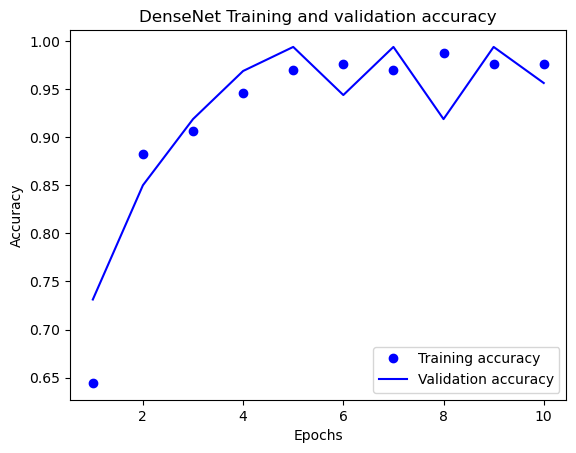

In [14]:
# Plot training and validation accuracy for DenseNet
acc_densenet = history_densenet.history['accuracy']
val_acc_densenet = history_densenet.history['val_accuracy']
epochs_densenet = range(1, len(acc_densenet) + 1)

plt.plot(epochs_densenet, acc_densenet, 'bo', label='Training accuracy')
plt.plot(epochs_densenet, val_acc_densenet, 'b', label='Validation accuracy')
plt.title('DenseNet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

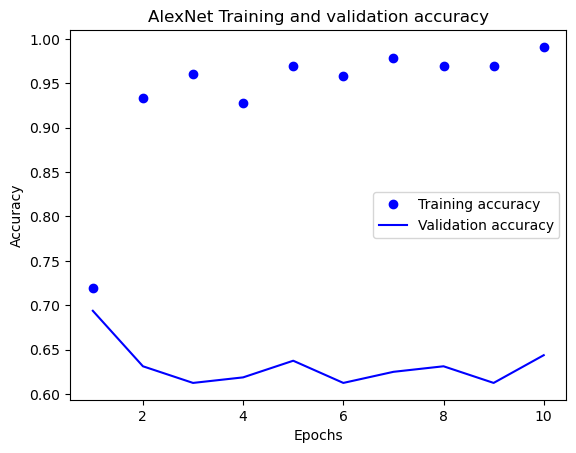

In [15]:
# Plot training and validation accuracy for AlexNet
acc_alexnet = history_alexnet.history['accuracy']
val_acc_alexnet = history_alexnet.history['val_accuracy']
epochs_alexnet = range(1, len(acc_alexnet) + 1)

plt.plot(epochs_alexnet, acc_alexnet, 'bo', label='Training accuracy')
plt.plot(epochs_alexnet, val_acc_alexnet, 'b', label='Validation accuracy')
plt.title('AlexNet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

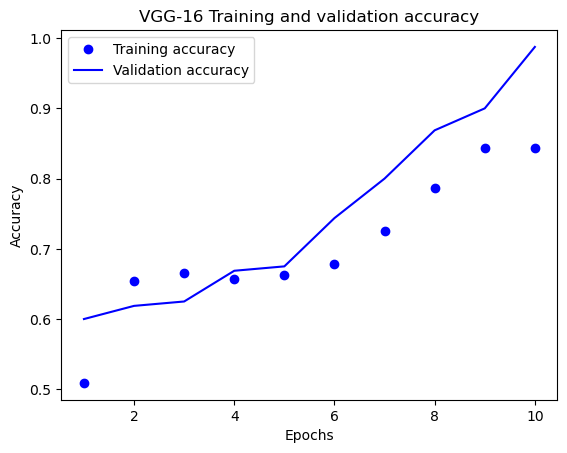

In [16]:
# Plot training and validation accuracy for VGG-16
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
epochs_vgg16 = range(1, len(acc_vgg16) + 1)

plt.plot(epochs_vgg16, acc_vgg16, 'bo', label='Training accuracy')
plt.plot(epochs_vgg16, val_acc_vgg16, 'b', label='Validation accuracy')
plt.title('VGG-16 Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()